In [118]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import itertools
import pylab
import math
import scipy.stats as stats

import sklearn.linear_model as skl_lm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import copy
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Airbnb Listings (Modeling)

#### Table of contents
* [Initial Analysis](#Initial-Analysis)
    * [Accommodation](#Accommodation)
    * [Reviews](#Reviews)
    * [Price and Zipcodes](#Price-and-Zipcodes)
    * [Price and Reviews](#Price-and-Reviews)

#### Loading the preprocessed Data

In [85]:
Data = pd.read_csv('Data/Clean_Airbnb_Listings.csv')
Lists_df = pd.read_csv('Data/Airbnb_Listings_Extra.csv')
Data.head().style.hide_index()

Extracting the lists

In [86]:
Properties_List=list(Lists_df.Properties_List[Lists_df.Properties_List!='0'])
Rooms_List=list(Lists_df.Rooms_List[Lists_df.Rooms_List!='0'])
Beds_List=list(Lists_df.Beds_List[Lists_df.Beds_List!='0'])
del Lists_df

## Initial Analysis

### Accommodation

In [87]:
Beds=pd.DataFrame(Data.groupby('beds').agg('count')['id'])
Beds

id
beds       
1     16405
2      5589
3      1786
4       618
5       245
6       120
7        41
8        22
9         3
10       20
11        4
12        9
13        1
14       15
16       27

In [88]:
Accommodates=pd.DataFrame(Data.groupby('accommodates').agg('count')['id'])
Accommodates

id
accommodates       
1              2757
2             11696
3              2957
4              4382
5               994
6              1231
7               219
8               335
9                58
10              123
11               15
12               44
13                5
14               14
15                5
16               70

Text(0,0.5,'Frequency')

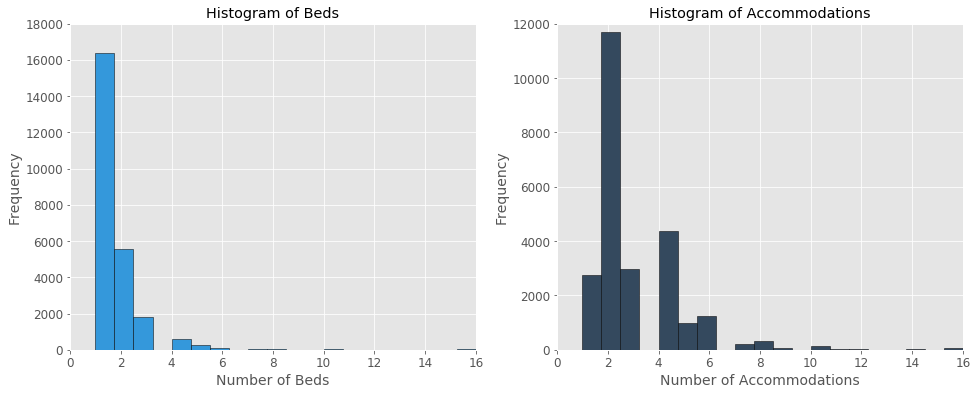

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharex=False)
# Left Plot
Data['beds'].hist(bins=20,ax=ax[0], color="#3498db", edgecolor="k")
ax[0].set_title('Histogram of Beds')
ax[0].set_xlim([0, 16])
ax[0].set_ylim([0, 18e3])
ax[0].set_xlabel('Number of Beds')
ax[0].set_ylabel('Frequency')
# Right Plot
Data['accommodates'].hist(bins=20,ax=ax[1],color="#34495e", edgecolor="k")
ax[1].set_title('Histogram of Accommodations')
ax[1].set_xlim([0, 16])
ax[1].set_ylim([0, 12e3])
ax[1].set_xlabel('Number of Accommodations')
ax[1].set_ylabel('Frequency')

It can be seen that the majority of listings have accommodations for 1-4 people. We also know that a bed accommodates two guests; therefore, we can also see that the majority of listed accommodations have a single bed.

In [90]:
def Correlation_Plot (Df,Fig_Size):
    Correlation_Matrix = Df.corr()
    mask = np.zeros_like(Correlation_Matrix)
    mask[np.triu_indices_from(mask)] = True
    for i in range(len(mask)):
        mask[i,i]=0
    plt.subplots(figsize=(Fig_Size,Fig_Size))
    sns.heatmap(Correlation_Matrix, mask=mask, annot=True, square=True, 
                cmap =sns.color_palette("RdBu", n_colors=10), linewidths = 0.2, vmin=0, vmax=1)

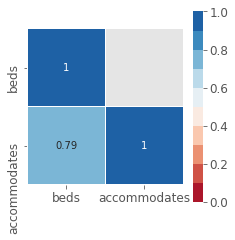

In [91]:
Correlation_Plot (Data[['beds','accommodates']], 3.5)

It also can be seen that these two parameters, **beds** and **accommodates** are highly correlated

In [92]:
Beds_df=pd.DataFrame(Data[Beds_List].sum(),columns=['Frequency'])
Beds_df

Frequency
Airbed               193
Couch                 98
Futon                446
Pull-out Sofa        290
Real Bed           23878

In [93]:
Rooms_df=pd.DataFrame(Data[Rooms_List].sum(),columns=['Frequency'])
Rooms_df

Frequency
Entire home/apt      13567
Private room         10516
Shared room            822

In [94]:
Properties_df=pd.DataFrame(Data[Properties_List].sum(),columns=['Frequency'])
Properties_df

Frequency
Apartment            22513
Bed & Breakfast        170
Boat                    11
Cabin                    3
Camper/RV                1
Castle                   1
Cave                     1
Chalet                   1
Dorm                    48
Earth House              1
House                 1536
Hut                      1
Lighthouse               1
Loft                   558
Other                   46
Tent                     3
Treehouse                6
Villa                    4

Text(0,0.5,'Frequency')

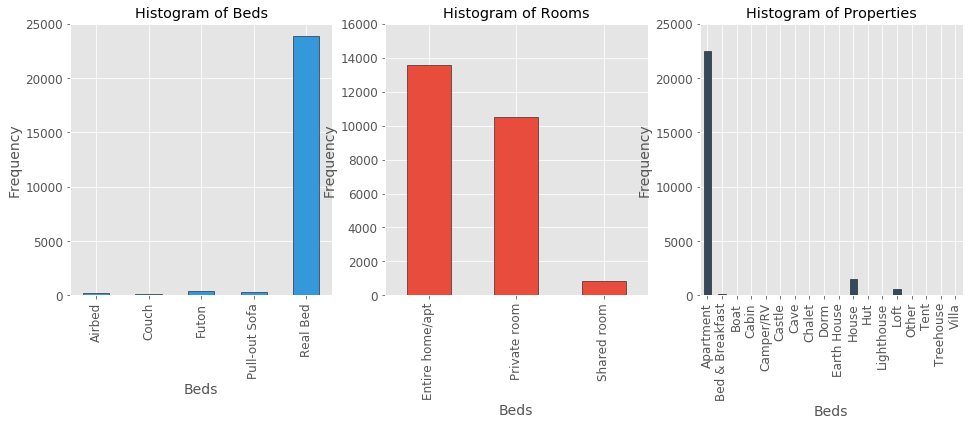

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 5), sharex=False)
#
Beds_df.plot(kind='bar', legend=False, ax=ax[0], color="#3498db", edgecolor="k")
ax[0].set_title('Histogram of Beds')
ax[0].set_ylim([0, 25e3])
ax[0].set_xlabel('Beds')
ax[0].set_ylabel('Frequency')
#
Rooms_df.plot(kind='bar', legend=False, ax=ax[1], color="#e74c3c", edgecolor="k")
ax[1].set_title('Histogram of Rooms')
ax[1].set_ylim([0, 16e3])
ax[1].set_xlabel('Beds')
ax[1].set_ylabel('Frequency')
#
Properties_df.plot(kind='bar', legend=False, ax=ax[2], color="#34495e", edgecolor="k")
ax[2].set_title('Histogram of Properties')
ax[2].set_ylim([0, 25e3])
ax[2].set_xlabel('Beds')
ax[2].set_ylabel('Frequency')

We can see that the majority of beds are real beds and apartments are the most popular ones amount properties. Moreover, most guests prefer to avoid shared rooms.

### Reviews

In [96]:
Columns_list=Data.columns
Review_list=list()
for i in range(len(Columns_list)):
    if Columns_list[i].find('review') != -1:
        Review_list.append(Columns_list[i])
Review=Data[Review_list]
Review.head().style.hide_index()

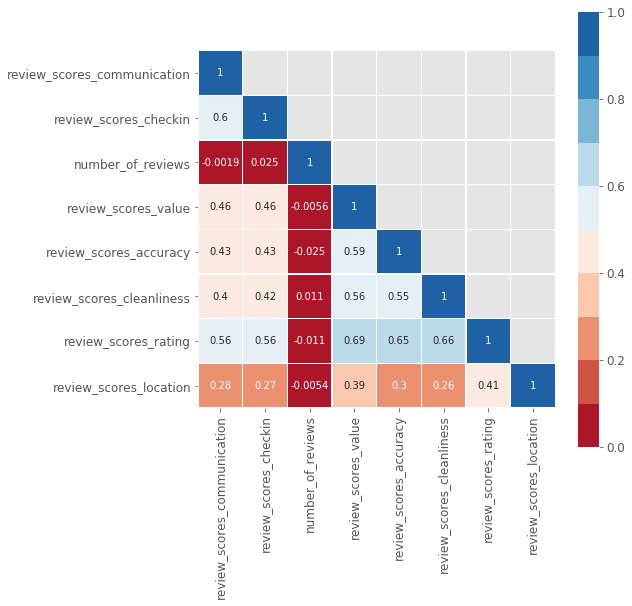

In [97]:
Correlation_Plot (Review, 8)

It seems that **number of reviews** and **review scores location** are insignifiancly correlated with the other rewivew paramters.

To see this better, note that

In [98]:
Review=Review.drop(columns=['number_of_reviews','review_scores_location'])

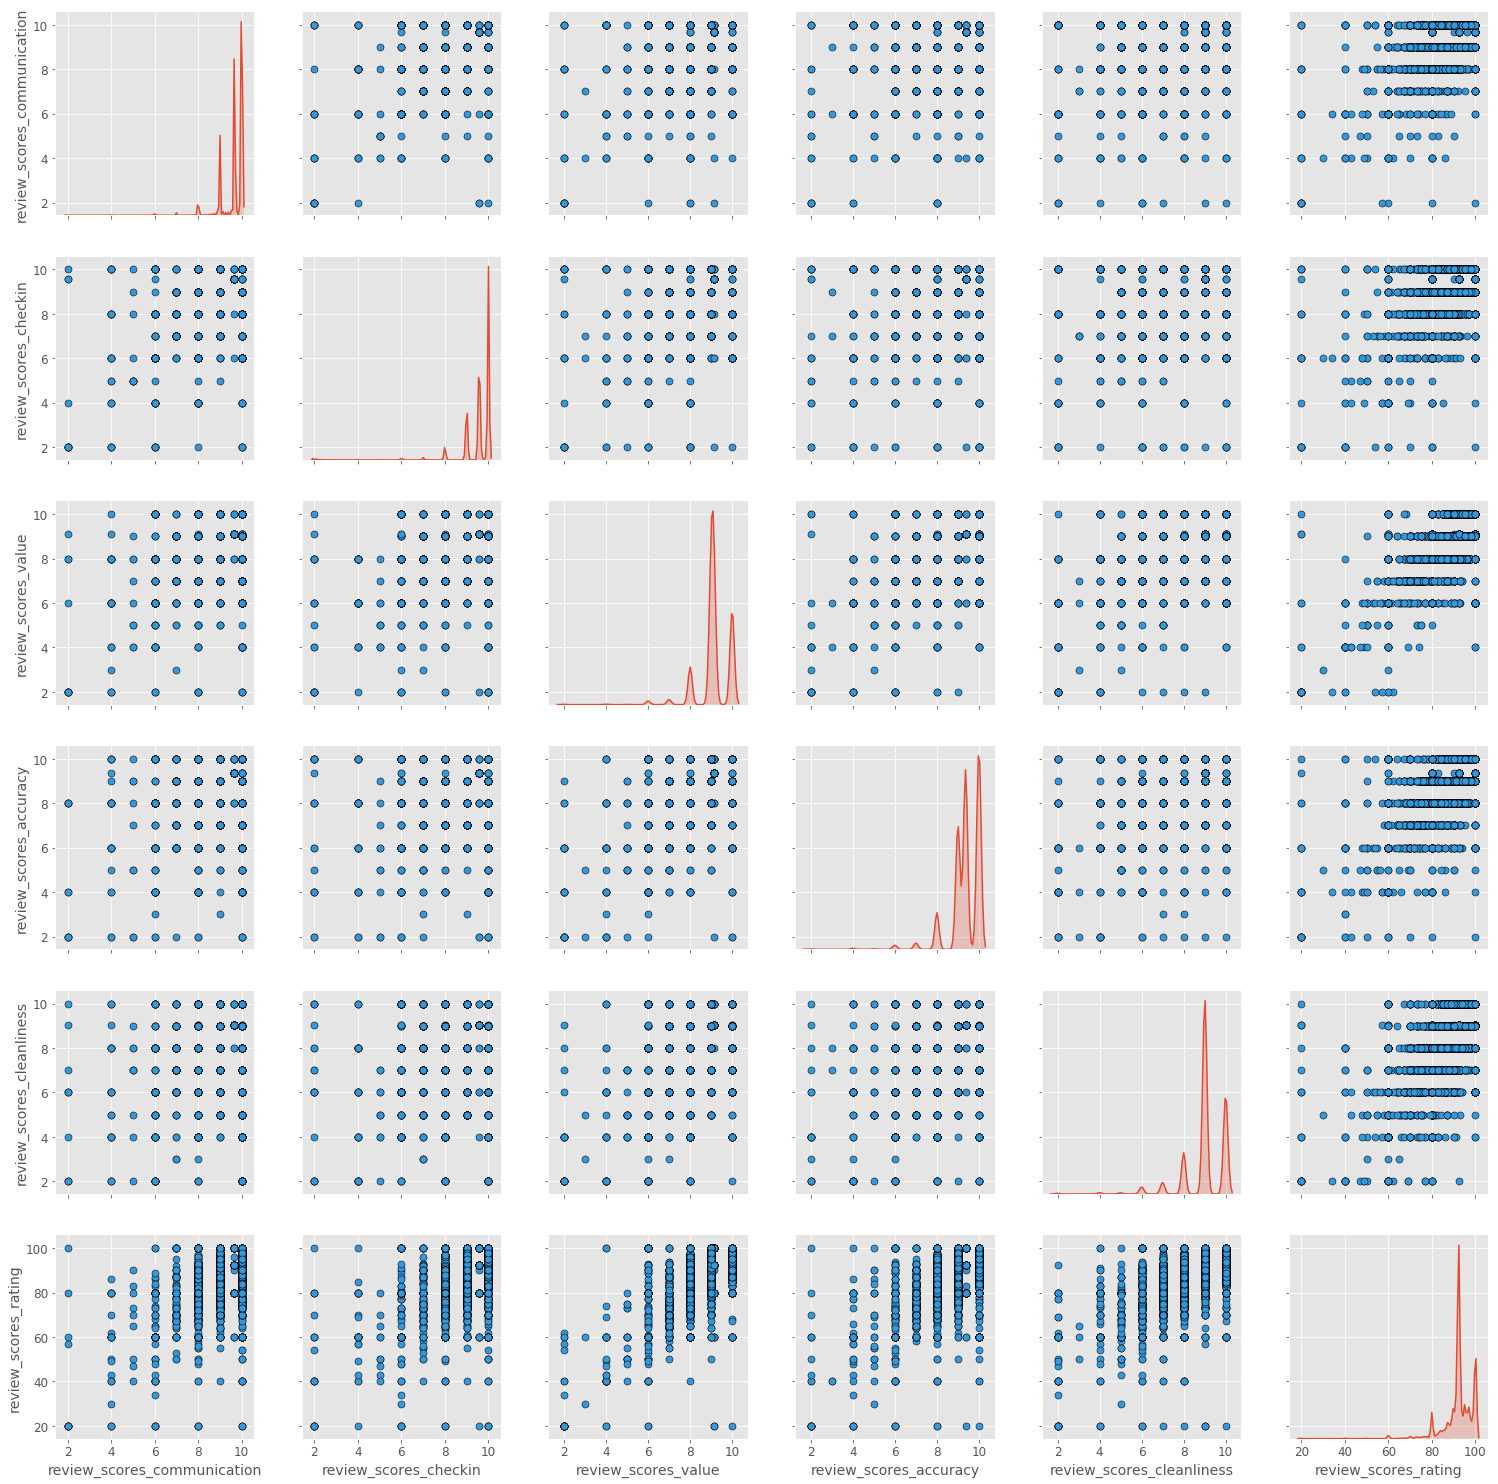

In [99]:
sns.pairplot(Review, height=3.5,diag_kind="kde", 
             plot_kws=dict(s=50, color="#3498db", edgecolor="k", linewidth=0.5),
             diag_kws=dict(shade=True))

### Price and Zipcodes

In [100]:
Columns_list=Data.columns
Price_list=list()
for i in range(len(Columns_list)):
    if Columns_list[i].find('price') != -1:
        Price_list.append(Columns_list[i])
Price=Data[Price_list]
pd.DataFrame(Price.mean(), columns=['mean'])

mean
price           171.685364
weekly_price    950.968222
monthly_price  3044.405497

Consider the most popular place (using their zip code)

In [101]:
Zip_df = pd.DataFrame(Data.zipcode.value_counts())

Text(0,0.5,'Frequency')

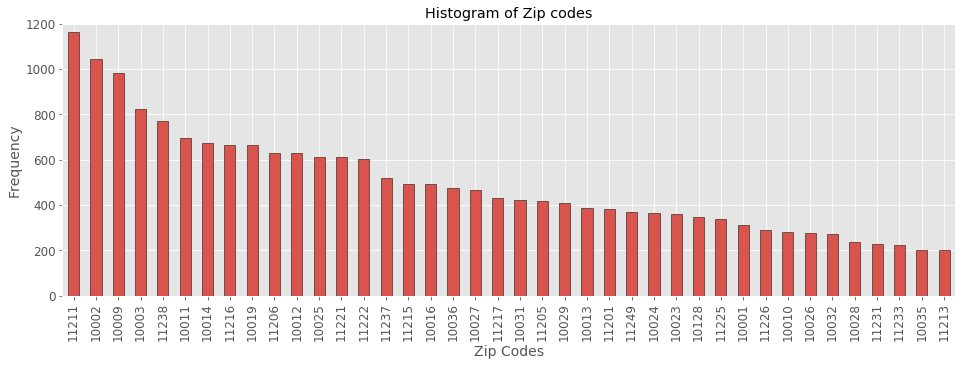

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5), sharex=False)
Zip_df[Zip_df.zipcode>200].plot(kind='bar', ax=ax, legend=False, color=sns.xkcd_rgb["pale red"], edgecolor="k")
ax.set_title('Histogram of Zip codes')
ax.set_ylim([0, 12e2])
ax.set_xlabel('Zip Codes')
ax.set_ylabel('Frequency')

In [103]:
Zip_list=Zip_df[Zip_df.zipcode>200].index
Zip_df=Data[['zipcode','price']]
Price_Zipcode=Zip_df.groupby('zipcode').mean().round(0)

Text(0,0.5,'Average Price')

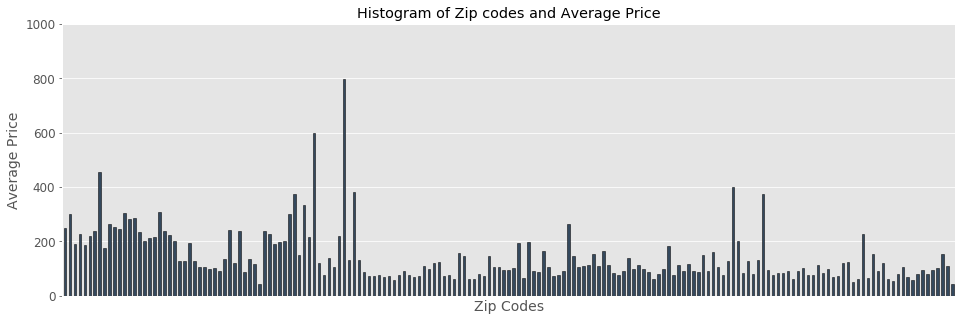

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5), sharex=False)
Price_Zipcode.plot(kind='bar', ax=ax, legend=False, color='#34495e', edgecolor="k")
ax.set_title('Histogram of Zip codes and Average Price')
ax.set_xticks([])
ax.set_ylim([0, 1e3])
ax.set_xlabel('Zip Codes')
ax.set_ylabel('Average Price')

### Price and Reviews

Creating a new dataframe with price and the average of ratings.

In [105]:
temp=list(Review.columns)
temp.insert(0,'price')
Price=Data[temp]
Price.review_scores_rating=np.round(Price.review_scores_rating/10)
Price['average_review']=0
Price['average_review']=np.round(Price[Review.columns.tolist()].mean(axis=1))
# Droping unessary columns
Price=Price.drop(columns=Review.columns.tolist())
Price.head()

price  average_review
0  160.0             9.0
1   58.0            10.0
2  185.0            10.0
3  195.0            10.0
4  165.0            10.0

In [106]:
Price['average_review']=Price['average_review'].astype('int')
Review_Price=Price.groupby('average_review').mean().round(0)
Review_Price.head()

price
average_review       
2               149.0
3               126.0
4               139.0
5               114.0
6               131.0

Text(0,0.5,'Average Price')

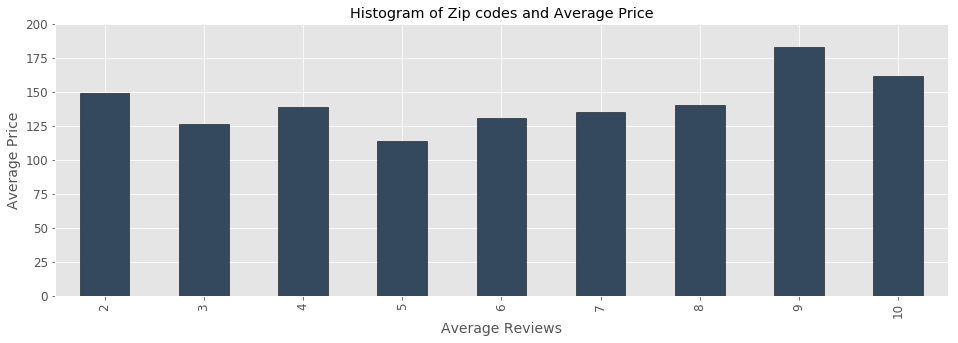

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 5), sharex=False)
Review_Price.plot(kind='bar', ax=ax, legend=False, color='#34495e', edgecolor="k")
ax.set_title('Histogram of Zip codes and Average Price')
ax.set_ylim([0, 2e2])
ax.set_xlabel('Average Reviews')
ax.set_ylabel('Average Price')

## Modeling 

### Train and Test Sets

Let's take another look at the Data parameters.

In [108]:
Data.columns

Index(['id', 'price', 'weekly_price', 'review_scores_communication', 'beds',
       'maximum_nights', 'host_id', 'review_scores_checkin', 'accommodates',
       'minimum_nights', 'availability_365', 'availability_60', 'bathrooms',
       'monthly_price', 'zipcode', 'availability_30', 'number_of_reviews',
       'review_scores_value', 'review_scores_accuracy', 'availability_90',
       'review_scores_cleanliness', 'review_scores_rating', 'host_since',
       'review_scores_location', 'bedrooms', 'Apartment', 'Bed & Breakfast',
       'Boat', 'Cabin', 'Camper/RV', 'Castle', 'Cave', 'Chalet', 'Dorm',
       'Earth House', 'House', 'Hut', 'Lighthouse', 'Loft', 'Other', 'Tent',
       'Treehouse', 'Villa', 'Entire home/apt', 'Private room', 'Shared room',
       'Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed'],
      dtype='object')

For this study, we do not need **id**, **host_id** and **host_since**

In [109]:
Data=Data.drop(columns=['id', 'host_id', 'host_since', 'weekly_price', 'monthly_price'])

Defining train and test sets:

In [110]:
X = Data.drop(columns='price')
y = Data['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [119]:
lReg = skl_lm.LogisticRegression(solver='newton-cg')
lReg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [120]:
Predict = lReg.predict(X_test)